In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:
loans = pd.read_csv('/content/drive/My Drive/ML Specialization/lending-club-data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# convert object dtype to string
loans = loans.convert_dtypes()

In [7]:
import json
with open('/content/drive/My Drive/ML Specialization/module-5-assignment-1-train-idx.json', 'r') as json_file:
    train_indices = json.load(json_file)
with open('/content/drive/My Drive/ML Specialization/module-5-assignment-1-validation-idx.json', 'r') as json_file:
    valid_indices = json.load(json_file)

In [8]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

In [9]:
print(len(loans[loans['safe_loans'] == 1]) / len(loans))
print(len(loans[loans['safe_loans'] == -1]) / len(loans))

0.8111853319957262
0.18881466800427382


In [10]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

In [11]:
loans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,1
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00,-1
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,1
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,1
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,1


In [12]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]
print("Number of safe loans  : %s" % len(safe_loans_raw))
print("Number of risky loans : %s" % len(risky_loans_raw))

Number of safe loans  : 99457
Number of risky loans : 23150


In [13]:
train_data = loans.iloc[train_indices]
valid_data = loans.iloc[valid_indices]

In [14]:
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if str(feat_type) == 'string':
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    for split in [train_data, valid_data]:
        loans_data_one_hot_encoded = pd.get_dummies(split[feature], prefix=feature)   

        # Change None's to 0's
        for column in loans_data_one_hot_encoded.columns:
            loans_data_one_hot_encoded[column] = loans_data_one_hot_encoded[column].fillna(0)
            split[column]= loans_data_one_hot_encoded[column]
        
        split.drop(feature, axis='columns', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
from sklearn.tree import DecisionTreeClassifier

small_model = DecisionTreeClassifier(max_depth=2)
decision_tree_model = DecisionTreeClassifier(max_depth=6)

Y = train_data['safe_loans']
X = train_data.drop('safe_loans', axis='columns')
small_model.fit(X.to_numpy(),Y.to_numpy())
decision_tree_model.fit(X.to_numpy(),Y.to_numpy())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(167.4, 181.2, 'grade_A <= 0.5\ngini = 0.5\nsamples = 37224\nvalue = [18476, 18748]\nclass = risky'),
 Text(83.7, 108.72, 'grade_B <= 0.5\ngini = 0.497\nsamples = 32094\nvalue = [17218, 14876]\nclass = safe'),
 Text(41.85, 36.23999999999998, 'gini = 0.483\nsamples = 21728\nvalue = [12875, 8853]\nclass = safe'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.487\nsamples = 10366\nvalue = [4343, 6023]\nclass = risky'),
 Text(251.10000000000002, 108.72, 'total_rec_late_fee <= 14.83\ngini = 0.37\nsamples = 5130\nvalue = [1258, 3872]\nclass = risky'),
 Text(209.25, 36.23999999999998, 'gini = 0.355\nsamples = 4987\nvalue = [1153, 3834]\nclass = risky'),
 Text(292.95, 36.23999999999998, 'gini = 0.39\nsamples = 143\nvalue = [105, 38]\nclass = safe')]

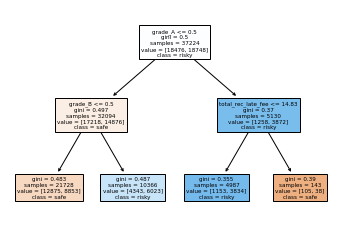

In [27]:
from sklearn.tree import plot_tree

plot_tree(small_model,
          feature_names=X.columns.to_numpy(),
          class_names=['safe', 'risky'],
          filled=True
          )

In [46]:
validation_safe_loans = valid_data[valid_data[target] == 1]
validation_risky_loans = valid_data[valid_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample = sample_validation_data.drop('safe_loans', axis='columns').to_numpy()
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [50]:
predictions = small_model.predict(sample)
np.sum(predictions == sample_validation_data['safe_loans']) / len(sample_validation_data)
print(predictions)
print(small_model.predict_proba(sample))

[ 1 -1 -1  1]
[[0.41896585 0.58103415]
 [0.59255339 0.40744661]
 [0.59255339 0.40744661]
 [0.23120112 0.76879888]]


In [54]:
X = train_data.drop('safe_loans', axis='columns').to_numpy()
Y = train_data['safe_loans'].to_numpy()
print('Train small model:', small_model.score(X, Y))
print('Train decision tree model:', decision_tree_model.score(X, Y))
X = valid_data.drop('safe_loans', axis='columns').to_numpy()
Y = valid_data['safe_loans'].to_numpy()
print('Valid small model:', small_model.score(X, Y))
print('Valid decision tree model:', decision_tree_model.score(X, Y))

Train small model: 0.6135020416935311
Train decision tree model: 0.6405276165914464
Valid small model: 0.6193451098664369
Valid decision tree model: 0.6363636363636364


In [55]:
from sklearn.tree import DecisionTreeClassifier

complex_model = DecisionTreeClassifier(max_depth=10)

Y = train_data['safe_loans']
X = train_data.drop('safe_loans', axis='columns')
complex_model.fit(X.to_numpy(),Y.to_numpy())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [57]:
X = train_data.drop('safe_loans', axis='columns').to_numpy()
Y = train_data['safe_loans'].to_numpy()
print('Train complex model:', complex_model.score(X, Y))
X = valid_data.drop('safe_loans', axis='columns').to_numpy()
Y = valid_data['safe_loans'].to_numpy()
print('Valid complex model:', complex_model.score(X, Y))

Train complex model: 0.6638459058671825
Valid complex model: 0.6261309780267126


In [79]:
data = valid_data.drop('safe_loans', axis='columns').to_numpy()
predictions = decision_tree_model.predict(data)
print('FP: ', np.sum(((predictions==1) & (valid_data['safe_loans']==-1))))
print('FN: ', np.sum(((predictions==-1) & (valid_data['safe_loans']==1))))

FP:  1661
FN:  1715
